In [100]:
import json

import pandas as pd

import gudhi as gd
import gudhi.wasserstein as wasserstein
import gudhi.hera as hera

from collections import defaultdict
from tqdm.notebook import tqdm

from itertools import combinations

import ripserplusplus as rpp

from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [101]:
cmap = 'viridis'

# Visualization

### Many models - many datasets

In [168]:
# datasets = [
#     'Synthetic/Circle', 
#     'Synthetic/2Clusters', 
#     'Synthetic/3Clusters', 
# #     'Synthetic/Infty', 
#     'Synthetic/RandomCube'
# ]

datasets = [
    'F-MNIST', 
#     'CaloGAN', 
#     'COIL-20',
#     'c.elegans'
]

models = {
#     'umap':'UMAP',
#     'tsne':'t-SNE',
#     'Basic AutoEncoder':'AE',
#     'Topological AutoEncoder':'TopoAE (Moor et.al.)',
#     'RTD AutoEncoder H1':'RTD',
    'RTD AutoEncoder H1 min_max':'RTD MM',
#     'RTD AutoEncoder H1 lp2':'RTD gL2',
#     'RTD AutoEncoder H1 min_max':'RTD-AE',
#     'RTD AutoEncoder H1 geodesic':'RTD g'
#     'RTD AutoEncoder H1 min_max':'RTD-AE-H1 MinMax',
#     'RTD AutoEncoder H1 lp2':'RTD-AE-H1 L2'
}
dataset_names = {'CaloGAN':'Calorimeter', 'RandomCube':'Random', '2Clusters':'2 Clusters', '3Clusters':'3 Clusters'}
version = 'batch150'

In [169]:
def plot_2d(latent, labels, alpha=0.7, title="", fontsize=25, s=2.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    scatter = ax.scatter(latent[:, 0], latent[:, 1], alpha=alpha, c=labels, s=s, label=labels)
#     legend = ax.legend(*scatter.legend_elements(num=len(np.unique(labels))), loc="upper left", title="Types")
#     ax.add_artist(legend)
    if len(title):
        ax.set_title(title, fontsize=fontsize)
    return ax

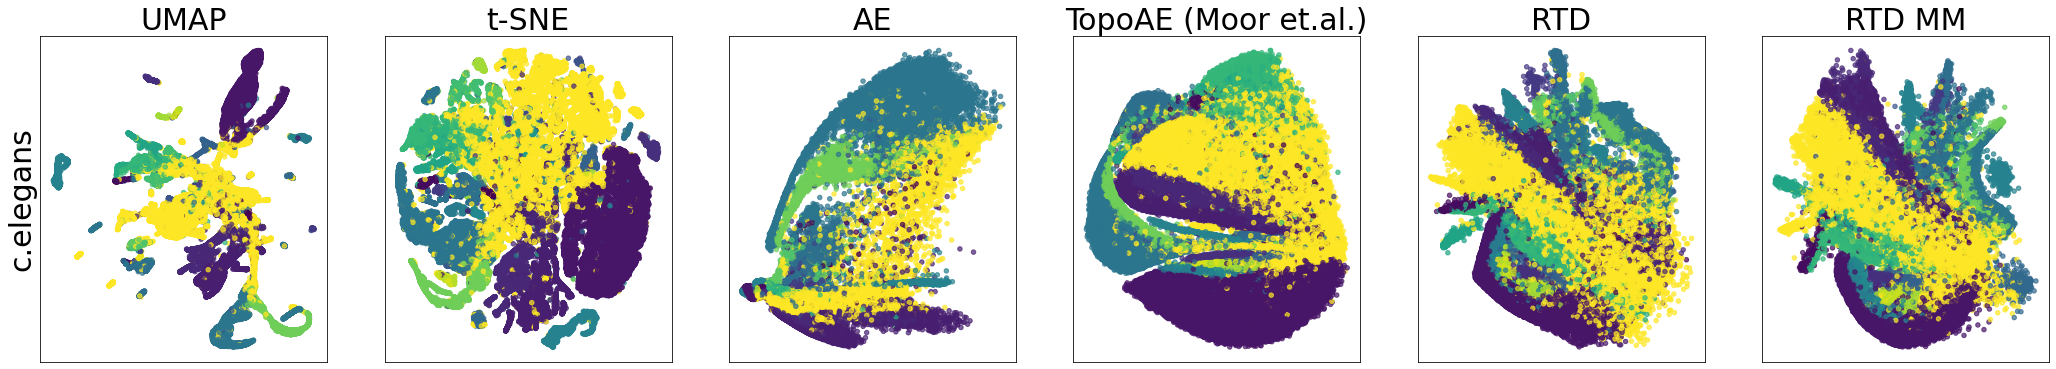

In [170]:
# plot multiple datasets latent representations
fig, axes = plt.subplots(len(datasets), len(models), figsize=(len(models)*6, len(datasets)*6), squeeze=False)
for i, dataset in enumerate(datasets):
    labels = None # refactor
    try:
        labels = np.load(f"data/{dataset}/prepared/train_labels.npy")
    except FileNotFoundError:
        pass
    try:
        labels = np.load(f"data/{dataset}/prepared/labels.npy")
    except FileNotFoundError:
        pass
    for j, name in enumerate(models):
        latent = None
        potential_filenames = [
            f'data/{dataset}/{name}_output_{version}.npy', 
            f'data/{dataset}/{name}_output_.npy', 
            f'data/{dataset}/{name}_output.npy'
        ]
        for n in potential_filenames:
            try:
                latent = np.load(n)
                break
            except FileNotFoundError:
                pass
        if latent is None:
            raise FileNotFoundError(f'No file for model: {name}, dataset: {dataset}')
        axes[i][j].scatter(latent[:, 0], latent[:, 1], c=labels, s=20.0, alpha=0.7, cmap='viridis')
        if i == 0:
            axes[i][j].set_title(f'{models[name]}', fontsize=30)
        if j == 0:
            d = dataset.split('/')[-1]
            d = dataset_names.get(d, d)
            axes[i][j].set_ylabel(d, fontsize=30)
        axes[i][j].tick_params(
            axis='both', 
            which='both', 
            bottom=False, 
            top=False,
            labelbottom=False,
            right=False,
            left=False,
            labelleft=False
        )

### Many datasets - original data

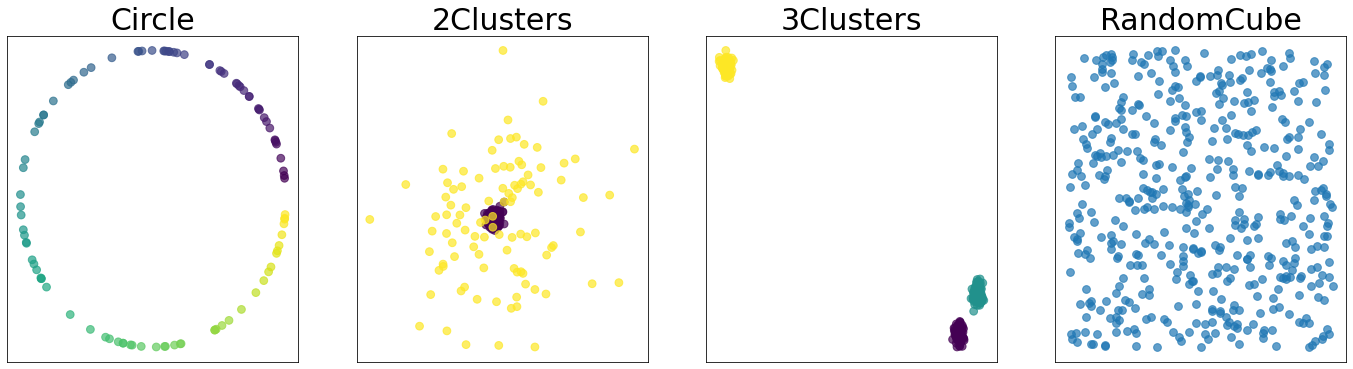

In [171]:
# original data
datasets = [
    'Synthetic/Circle', 
    'Synthetic/2Clusters', 
    'Synthetic/3Clusters', 
#     'Synthetic/Infty', 
    'Synthetic/RandomCube'
]

fig, axes = plt.subplots(1, len(datasets), figsize=(len(datasets)*6, 6*1))

for i, dataset in enumerate(datasets):
    labels = None # refactor
    try:
        labels = np.load(f"data/{dataset}/prepared/train_labels.npy")
    except FileNotFoundError:
        pass
    try:
        labels = np.load(f"data/{dataset}/prepared/labels.npy")
    except FileNotFoundError:
        pass
    try:
        data = np.load(f'data/{dataset}/prepared/train_data.npy')
    except FileNotFoundError:
        data = np.load(f'data/{dataset}/prepared/data.npy')
    name = dataset.split('/')[-1]
    axes[i].scatter(data[:, 0], data[:, 1], c=labels, s=60.0, alpha=0.7, cmap=cmap)
    axes[i].set_title(name, fontsize=30)
    axes[i].tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        top=False,
        labelbottom=False,
        right=False,
        left=False,
        labelleft=False
    )

### One dataset - many models

In [212]:
dataset_name = 'CaloGAN'
version = ''

models = {
    'umap':'UMAP',
    'tsne':'t-SNE',
    'Basic AutoEncoder':'AE',
    'Topological AutoEncoder':'TopoAE (Moor et.al.)',
    'RTD AutoEncoder H1':'RTD-AE-H1'
#     'RTD AutoEncoder H1 min_max':'RTD-AE-H1 MinMax',
#     'RTD AutoEncoder H1 lp2':'RTD-AE-H1 L2'
}

IndexError: index 4 is out of bounds for axis 0 with size 1

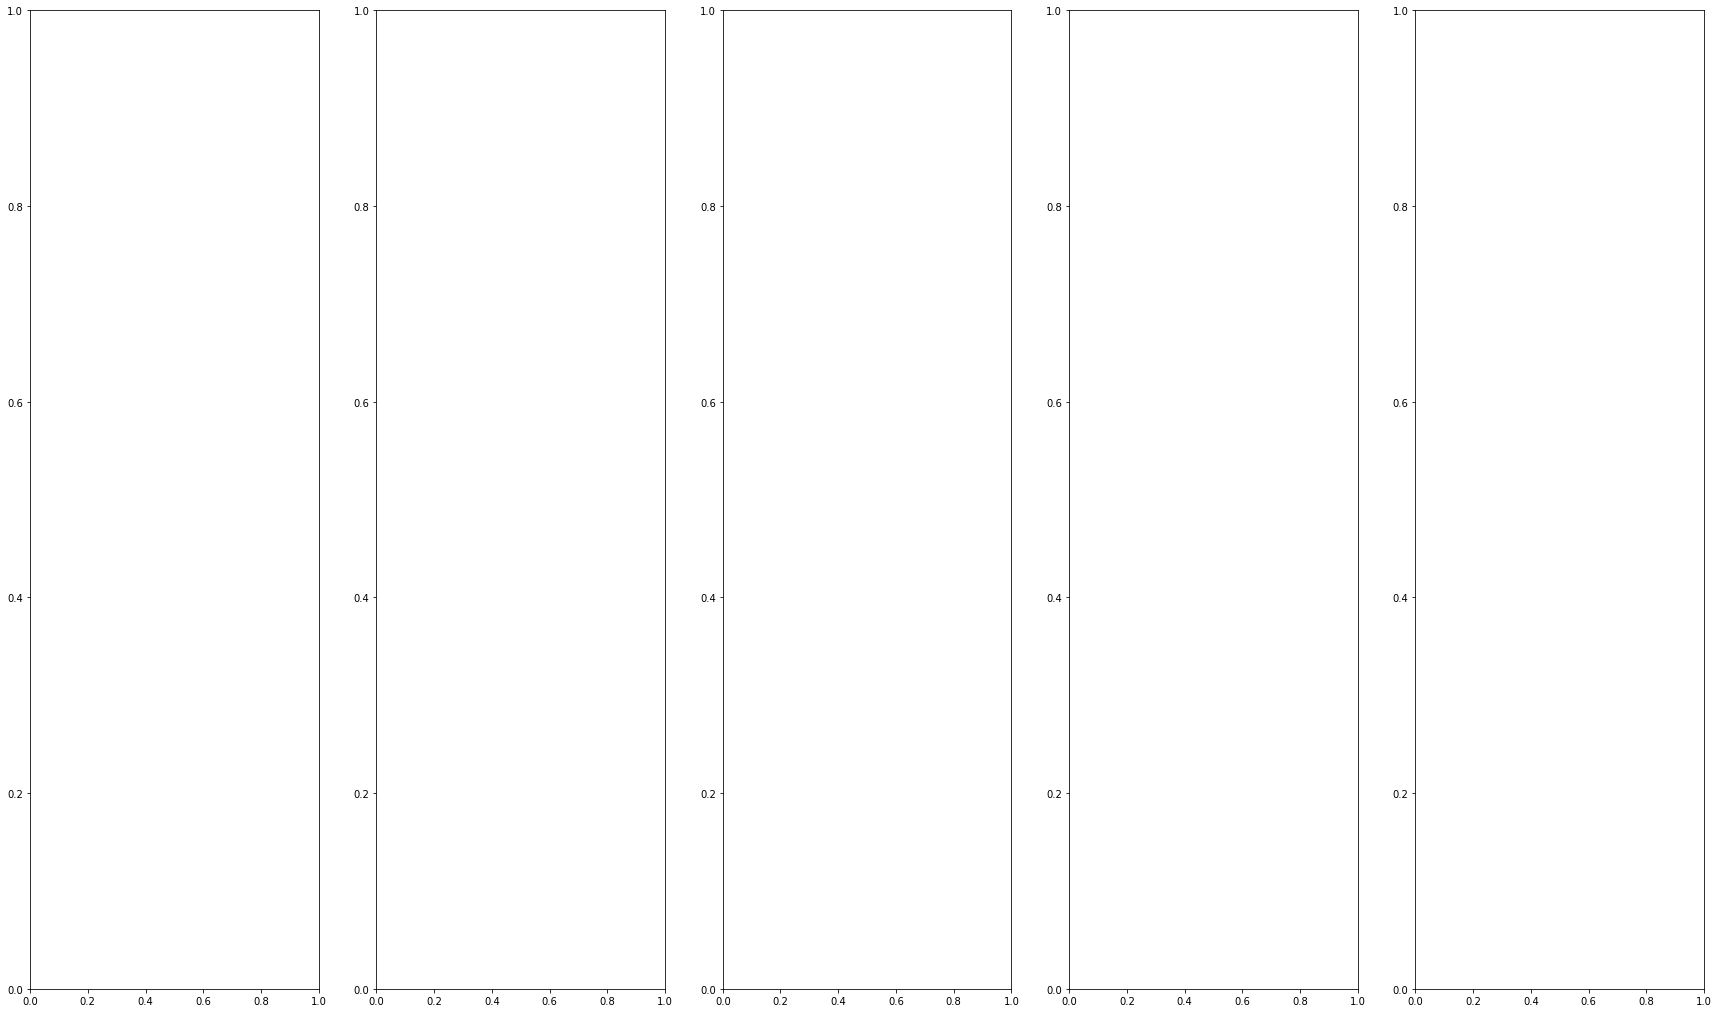

In [213]:
fig, axes = plt.subplots(1, len(models), figsize=(len(models)*6, len(datasets)*6), squeeze=False)
for j, name in enumerate(models):
    try:
        latent = np.load(f'data/{dataset}/{name}_output_{version}.npy')
    except FileNotFoundError:
        latent = np.load(f'data/{dataset}/{name}_output.npy')
    axes[i][j].scatter(latent[:, 0], latent[:, 1], c=labels, s=20.0, alpha=0.7, cmap='viridis')
    if i == 0:
        axes[i][j].set_title(f'{models[name]}', fontsize=30)
    if j == 0:
        d = dataset.split('/')[-1]
        d = dataset_names.get(d, d)
        axes[i][j].set_ylabel(d, fontsize=30)
    axes[i][j].tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        top=False,
        labelbottom=False,
        right=False,
        left=False,
        labelleft=False
    )

# Metrics

In [249]:
dataset_name = 'COIL-20'
version = 'geodesic_batch150'

models = {
#     'umap':'UMAP',
#     'tsne':'t-SNE',
#     'Basic AutoEncoder':'AE',
#     'Topological AutoEncoder':'TopoAE (Moor et.al.)',
    'RTD AutoEncoder H1':'RTD g',
    'RTD AutoEncoder H1 min_max':'RTD gMM',
    'RTD AutoEncoder H1 lp2':'RTD gL2'
}

## Pearson correlation for pairwise distances

In [250]:
try:
    labels = np.load(f'data/{dataset_name}/prepared/train_labels.npy')
except FileNotFoundError:
    labels = np.load(f'data/{dataset_name}/prepared/train_data.npy')
ids = np.random.choice(np.arange(0, len(labels)), size=min(6000, len(labels)), replace=False)

def get_distances(data):
    data = data.reshape(data.shape[0], -1)
    distances = distance_matrix(data, data)
    distances = distances[np.triu(np.ones_like(distances), k=1) > 0]
    return distances

original_distances = get_distances(np.load(f'data/{dataset_name}/prepared/train_data.npy')[ids])
 # take only different 

In [251]:
labels.shape

(1440,)

In [217]:
results = {}
for model_name in models:
    try:
        latent_distances = get_distances(np.load(f'data/{dataset_name}/{model_name}_output_{version}.npy')[ids])
    except FileNotFoundError:
        continue
    results[model_name] = pearsonr(latent_distances, original_distances)[0]

In [218]:
results

{'umap': 0.7675991695306292,
 'tsne': 0.5640051314030154,
 'Basic AutoEncoder': 0.9877103147590289,
 'Topological AutoEncoder': 0.9572660334853673,
 'RTD AutoEncoder H1': 0.9944688092763793}

## Accuracy

In [200]:
version

'batch150'

In [201]:
train_labels = np.load(f"data/{dataset_name}/prepared/train_labels.npy")
is_there_test = True
try:
    test_labels = np.load(f"data/{dataset_name}/prepared/test_labels.npy")
except FileNotFoundError:
    is_there_test = False
    train_ids, test_ids = train_test_split(np.arange(0, len(train_labels)), test_size=0.2)
    test_labels = train_labels[test_ids]
    train_labels = train_labels[train_ids]
    
results = defaultdict(dict)

for model_name in models:
    try:
        train_data = np.load(f'data/{dataset_name}/{model_name}_output_{version}.npy')
    except FileNotFoundError:
        continue
    if is_there_test:
        test_data = np.load(f'data/{dataset_name}/{model_name}_output_{version}_test.npy')
    else:
        test_data = train_data[test_ids]
        train_data = train_data[train_ids]
#         print('test_data not found')
#     for k in [3, 5, 10, 50, 100]:
#         classifier = KNeighborsClassifier(n_neighbors=k)
#         classifier.fit(train_data, train_labels)
#         results[model_name][f'knn_k{k}'] = accuracy_score(test_labels, classifier.predict(test_data))
    C = 1.0
    classifier = SVC(C=C)
    classifier.fit(train_data, train_labels)
    results[model_name][f'svm_C{C}'] = accuracy_score(test_labels, classifier.predict(test_data))

In [202]:
results

defaultdict(dict,
            {'RTD AutoEncoder H1 min_max': {'svm_C1.0': 0.6609},
             'RTD AutoEncoder H1 lp2': {'svm_C1.0': 0.6519}})

In [203]:
pd.DataFrame.from_dict(results)

,RTD AutoEncoder H1 min_max,RTD AutoEncoder H1 lp2
svm_C1.0,0.6609,0.6519


## Wasserstein

In [252]:
def calculate_persistence_gd(distances, dim=3):
    skeleton = gd.RipsComplex(distance_matrix = distances)
    simplex_tree = skeleton.create_simplex_tree(max_dimension=dim)
    barcodes = simplex_tree.persistence()
    pbarcodes = {}
    for i in range(dim):
        pbarcodes[i] = [[b[1][0], b[1][1]] for b in barcodes if b[0] == i]
    return pbarcodes


def cast_to_normal_array(barcodes):
    return np.array([[b, d] for b, d in barcodes])

In [253]:
n_runs = 5
batch_size = 2048
max_dim = 1


results = defaultdict(dict)

for i in range(n_runs):
    wresults = defaultdict(dict)
    data = np.load(f'data/{dataset_name}/prepared/train_data.npy')
    ids = np.random.choice(np.arange(0, len(data)), size=min(batch_size, len(data)), replace=False)
    
    data = data.reshape(len(data), -1)[ids]
    distances = distance_matrix(data, data)
    distances = distances/np.percentile(distances.flatten(), 90)
    
    barcodes = {'original':rpp.run(f'--format distance --dim {max_dim}', data=distances)}
    datasets = {'original':data}
    
    for model_name in models:
        try:
            data = np.load(f'data/{dataset_name}/{model_name}_output_{version}.npy')
            data = data.reshape(len(data), -1)[ids]
            distances = distance_matrix(data, data)
            distances = distances/np.percentile(distances.flatten(), 90)
            barcodes[model_name] = rpp.run(f'--format distance --dim {max_dim}', data=distances)
            datasets[model_name] = data
        except FileNotFoundError:
            continue
        for dim in range(max_dim+1):
            if model_name not in results[dim]:
                results[dim][model_name] = []
            results[dim][model_name].append(hera.wasserstein_distance(
                cast_to_normal_array(barcodes['original'][dim]), 
                cast_to_normal_array(barcodes[model_name][dim]),
                internal_p=2
            ))

In [254]:
for dim in range(max_dim+1):
    print(f'Dimension: {dim}')
    for model_name in results[dim]:
        print(f"Model: {model_name}: {np.mean(results[dim][model_name]):.3f} +- {np.std(results[dim][model_name]):.3f}")

Dimension: 0
Model: RTD AutoEncoder H1: 204.476 +- 0.000
Model: RTD AutoEncoder H1 min_max: 200.663 +- 0.000
Model: RTD AutoEncoder H1 lp2: 201.217 +- 0.000
Dimension: 1
Model: RTD AutoEncoder H1: 9.135 +- 0.000
Model: RTD AutoEncoder H1 min_max: 9.182 +- 0.000
Model: RTD AutoEncoder H1 lp2: 8.879 +- 0.000


In [77]:
plt.figure(figsize=(6, 6))
plt.scatter(data['original'][:, 0], data['original'][:, 1])
plt.title("Original data", fontsize=25)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for dim in barcodes['original']:
    gd.plot_persistence_barcode(barcodes['original'][dim], axes=axes[dim])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 432x432 with 0 Axes>

In [ ]:
results = pd.DataFrame.from_dict(results).T

In [ ]:
results[['umap', 'tsne', 'Basic AutoEncoder', 'Topological AutoEncoder', 'RTD AutoEncoder H1', 'RTD AutoEncoder H2']]

## Triplet accuracy

In [152]:
# dataset_name = 'COIL-20'
# version = "geodesic"
# models = {
#     'umap':'UMAP',
#     'tsne':'t-SNE',
#     'Basic AutoEncoder':'AE',
#     'Topological AutoEncoder':'TopoAE (Moor et.al.)',
#     'RTD AutoEncoder H1':'RTD-AE-H1',
#     'RTD AutoEncoder H2':'RTD-AE-H2'
# }

In [255]:
def triplet_accuracy(input_data, latent_data, triplets=None):
    # calculate distance matricies
    input_data = input_data.reshape(input_data.shape[0], -1)
    input_distances = distance_matrix(input_data, input_data)
    latent_data = latent_data.reshape(latent_data.shape[0], -1)
    latent_distances = distance_matrix(latent_data, latent_data)
    # generate triplets
    if triplets is None:
        triplets = np.asarray(list(combinations(range(len(input_data)), r=3)))
    i_s = triplets[:, 0]
    j_s = triplets[:, 1]
    k_s = triplets[:, 2]
    acc = (np.logical_xor(
        input_distances[i_s, j_s] < input_distances[i_s, k_s], 
        latent_distances[i_s, j_s] < latent_distances[i_s, k_s]
    ) == False)
    acc = np.mean(acc.astype(np.int32))
    return acc


def avg_triplet_accuracy(input_data, latent_data, batch_size=128, n_runs=20):
    # average over batches
    accs = []
    triplets = np.asarray(list(combinations(range(min(batch_size, len(input_data))), r=3)))
    if batch_size > len(input_data):
        accs.append(triplet_accuracy(input_data, latent_data, triplets=triplets))
        return accs
    for _ in range(n_runs):
        ids = np.random.choice(np.arange(len(input_data)), size=batch_size, replace=False)
        accs.append(triplet_accuracy(input_data[ids], latent_data[ids], triplets=triplets))
    return accs

In [256]:
input_data = np.load(f'data/{dataset_name}/prepared/train_data.npy')

for model_name in models:
    try:
        latent_data = np.load(f'data/{dataset_name}/{model_name}_output_{version}.npy')
    except FileNotFoundError:
        continue
    accs = avg_triplet_accuracy(input_data, latent_data, batch_size=150, n_runs=10)
    print(f"Model: {model_name}, triplet acc: {np.mean(accs):.3f} ± {np.std(accs):.3f}")

Model: RTD AutoEncoder H1, triplet acc: 0.700 ± 0.011
Model: RTD AutoEncoder H1 min_max, triplet acc: 0.703 ± 0.018
Model: RTD AutoEncoder H1 lp2, triplet acc: 0.643 ± 0.006


In [64]:
dataset_name = ''

In [98]:
train_size = np.load(f'data/{dataset_name}/prepared/train_data.npy').shape[0]
try:
    test_size = np.load(f'data/{dataset_name}/prepared/test_data.npy').shape[0]
except FileNotFoundError:
    test_size = 0
print(f"Train size: {train_size}\nTest size: {test_size}\nOverall size: {test_size + train_size}")

Train size: 300
Test size: 0
Overall size: 300


In [209]:
np.load('data/c.elegans/prepared/train_data.npy').shape

(86024, 100)

In [210]:
np.load('data/c.elegans/prepared/train_labels.npy')

array([36, 14, 36, ...,  3, 36,  3])